In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Funnynet

## A neural network that makes jokes

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

In [2]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math, random

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [4]:
files = list(PATH.iterdir())
print(files)

[PosixPath('data/stupidstuff.json'), PosixPath('data/reddit_jokes.json')]


In [5]:
for fname in files:
    if "eddit" in str(fname):
        reddit_dataset = str(fname)
    if "upid" in str(fname):
        stupid_dataset = str(fname)
reddit_jokes = json.load(open(reddit_dataset))
stupid_jokes = json.load(open(stupid_dataset))

In [6]:
len(reddit_jokes)

194553

In [7]:
reddit_jokes[0]

{'body': 'Now I have to say "Leroy can you please paint the fence?"',
 'id': '5tz52q',
 'score': 1,
 'title': 'I hate how you cant even say black paint anymore'}

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [8]:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

In [9]:
len(rated_jokes)

132992

In [10]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

Let's see how many jokes have really high scores:

In [11]:
len([score for score in scores if score>5000])

1067

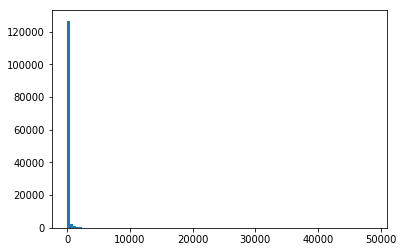

In [12]:
plt.hist(scores, bins=100);

Looks like there's quite a dropoff of scores, almost none above 1000. Score normalization or something might be useful -- a large amount of the score is probably due to posting time, so it might be valuable to batch all the score into "unpopular", "semi-popular", and "very popular" or something.

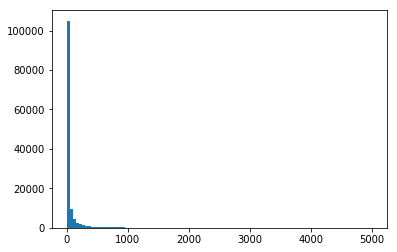

In [13]:
low_scores = [score for score in scores if score<5000]
plt.hist(low_scores, bins=100);

Here are the Reddit joke score incidences plotted on a log scale on the y axis:

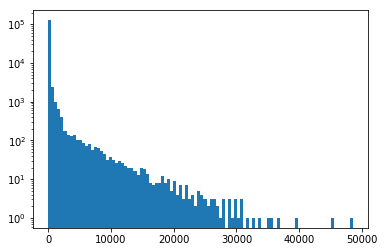

In [14]:
low_scores = [score for score in scores]
plt.yscale('log', nonposy='clip')
plt.hist(low_scores, bins=100);

Here are the Reddit joke score incidences plotted on a log scale on the x axis:

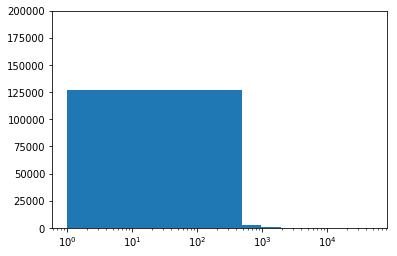

In [15]:
low_scores = [score for score in scores]
plt.xscale('log', nonposx='clip')
plt.ylim(ymax=200000)
#plt.axes.set_ylim([0,200000])
plt.hist(low_scores, bins=100);

In [16]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

'I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"'

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string, using the `EOJ` tag.

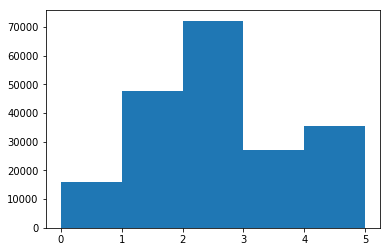

In [17]:
all_jokes = []
for i in range(len(reddit_jokes)):
    r_joke = reddit_jokes[i]
    #|print(r_joke)
    r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
    if r_joke['rating']>5:
        r_joke['rating']=5
    del r_joke['score'] 
    r_joke['body'] = r_joke['title']+" "+r_joke['body']
    del r_joke['title']
for s_joke in stupid_jokes:
    del s_joke['category']

combined = [joke['rating'] for joke in reddit_jokes]
combined = combined + [joke['rating'] for joke in stupid_jokes]
plt.hist(combined,bins=5);

combined_jokes = reddit_jokes + stupid_jokes

title_body = [joke['body']+' ' for joke in combined_jokes]

In [18]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 800000: 
        break

In [19]:
len(text)
print(text[1000:1100])

ls ‘Jesus Christ, are you still in there?'”  xeoj  You hear about the University book store worker w


In [20]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 125


In [21]:
chars.insert(0, "\0")
print(chars)

['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '\u2028', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


It appears there are Emojis in the dataset. 

In [22]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [23]:
idx = [char_indices[c] for c in text]

idx[:10]

[3, 44, 3, 75, 68, 87, 72, 3, 75, 82]

In [24]:
''.join(indices_char[i] for i in idx[:70])

' I hate how you cant even say black paint anymore Now I have to say "L'

# Emojis in Jokes

How many of them have them?

In [25]:
emojis = chars[-3:]

def containsEmoji(joke):
    for emoji in emojis:
        if emoji in joke:
            return True
    return False

#type(title_body[0])
contains_emoji = [joke for joke in title_body if containsEmoji(joke)]
print(len(contains_emoji))
# contains_emoji

49


So not that many. 
Interestingly though, there seems to be more emojis than we found initially. 

## Three character model

In [26]:
len(idx)

800048

In [27]:
cs = 3
c1_data = c2_data = c3_data = c4_data = []
for i in range(0, len(idx)-cs, cs):
    c1_data.append(idx[i])
    c2_data.append(idx[i+1])
    c3_data.append(idx[i+2])
    c4_data.append(idx[i+3])

### Create the input and outputs of our RNN

In [28]:
x1 = np.stack(c1_data)
x2 = np.stack(c2_data)
x3 = np.stack(c3_data)
y  = np.stack(c4_data)

### Create and train model

In [29]:
n_hidden = 256
embeddings_sz = 42 # size of embeddings matrix

In [30]:
# These libraries require some setup, try the pip install git+https.github.com/... trick
from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

In [31]:
class ThreeCharRNN(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1))) # Why relu?
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))

In [32]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

In [33]:
model = ThreeCharRNN(vocab_size, embeddings_sz).cuda()

In [34]:
train_iterator = iter(md.trn_dl)
*xs,yt = next(train_iterator)
t = model(*V(xs))

In [35]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [36]:
fit(model, md, epochs=1, opt=optimizer, crit=F.nll_loss) # The negative log likelihood loss

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.002085   0.000111  



[0.00011062622]

In [37]:
def get_next(input):
   running_indicies = []
   indicies = []
   for char in input:
       running_indicies.append(char_indices[char])
   for i in range(10):
       indicies = np.array(running_indicies[-3:])
       indicies = T(indicies)
       prediction = model(*VV(indicies))
       pred_idx = np.argmax(to_np(prediction))
       running_indicies.append(pred_idx)
   result_chars = []
   for index in running_indicies:
       result_chars.append(chars[index])
   return result_chars

In [38]:
get_next('y. ')

['y', '.', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [39]:
get_next('the')

['t', 'h', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e']

In [40]:
get_next('blo')

['b', 'l', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']

In [41]:
print(chars)

['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '\u2028', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


### Let's create a bigger RNN!

In [42]:
rnn_len=8

In [43]:
# char_in_jokes = [[idx[i+j] for i in range(rnn_len)] for j in range(len(idx)-rnn_len)]

char_input = []
for j in range(len(idx)-rnn_len):
    tmp = []
    for i in range(rnn_len):
        tmp.append(idx[i+j])
    char_input.append(tmp)

In [44]:
char_output = []
for j in range(len(idx)-rnn_len):
    char_output.append(idx[j+rnn_len])

In [45]:
xs = np.stack(char_input, axis=0)

In [46]:
xs.shape

(800040, 8)

In [47]:
y = np.stack(char_output)
y.shape

(800040,)

In [48]:
xs[:rnn_len,:rnn_len]

array([[ 3, 44,  3, 75, 68, 87, 72,  3],
       [44,  3, 75, 68, 87, 72,  3, 75],
       [ 3, 75, 68, 87, 72,  3, 75, 82],
       [75, 68, 87, 72,  3, 75, 82, 90],
       [68, 87, 72,  3, 75, 82, 90,  3],
       [87, 72,  3, 75, 82, 90,  3, 92],
       [72,  3, 75, 82, 90,  3, 92, 82],
       [ 3, 75, 82, 90,  3, 92, 82, 88]])

In [49]:
len(y[:rnn_len])

8

In [50]:
val_idx = get_cv_idxs(len(idx)-rnn_len-1)
# val_idx.shape
model_data = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [51]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
#         pdb.set_trace()
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
            
        return F.log_softmax(self.l_out(h), dim=-1)

In [52]:
model = CharLoopModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(model.parameters(), 1e-2)

In [53]:
fit(model, model_data, epochs=1, opt=opt, crit=F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      2.050437   2.05508   



[2.05508]

In [54]:
set_lrs(opt, 0.001)

In [55]:
fit(model, model_data, epochs=1, opt=opt, crit=F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      1.79886    1.800415  



[1.8004147]

In [56]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = model(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [57]:
get_next('for thos')

'e'

In [58]:
get_next(' a blond')

' '

In [59]:
get_next('into a b')

'e'

In [60]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [61]:
get_next_n('into a b', 40)

'into a be the said the said the said the said th'

In [62]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = torch.cat((h, self.e(c)), 1)
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [63]:
m = CharLoopConcatModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [64]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [65]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.000262   0.000197  



[0.00019741058]

In [66]:
set_lrs(opt, 1e-4)

In [67]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.000452   0.000144  



[0.00014400482]

In [68]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [69]:
get_next('for thos')

'6'

In [70]:
get_next('part of ')

'p'

In [71]:
get_next('queens a')

'🇰'

### Model with Multiple Outputs

In [72]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [73]:
m = CharRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [74]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [75]:
t = m.e(V(torch.stack(xs)))
t.size()

torch.Size([3, 512, 42])

In [76]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

(torch.Size([3, 512, 256]), torch.Size([1, 512, 256]))

In [77]:
t = m(*V(xs)); t.size()

torch.Size([512, 125])

In [78]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.000201   0.00025   
    1      0.000305   0.000109                                    
    2      1.2e-05    2.5e-05                                     
    3      2e-06      4e-06                                       



[3.8146973e-06]

In [79]:
set_lrs(opt, 1e-4)

In [80]:
fit(m, md, 2, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      1e-06      2e-06     
    1      1e-06      2e-06                                       



[1.9073486e-06]

In [81]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [82]:
get_next('for thos')

'/'

In [83]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [84]:
get_next_n('for thos', 40)

'for thos/// /////// /////// /////// /////// ////'

In [85]:
c_in_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(0, len(idx)-rnn_len-1, rnn_len)]

In [86]:
c_out_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(1, len(idx)-rnn_len, rnn_len)]

In [87]:
xs = np.stack(c_in_dat)
xs.shape

(100005, 8)

In [88]:
xs[:rnn_len,:rnn_len]

array([[ 3, 44,  3, 75, 68, 87, 72,  3],
       [75, 82, 90,  3, 92, 82, 88,  3],
       [70, 68, 81, 87,  3, 72, 89, 72],
       [81,  3, 86, 68, 92,  3, 69, 79],
       [68, 70, 78,  3, 83, 68, 76, 81],
       [87,  3, 68, 81, 92, 80, 82, 85],
       [72,  3, 49, 82, 90,  3, 44,  3],
       [75, 68, 89, 72,  3, 87, 82,  3]])

In [89]:
ys = np.stack(c_out_dat)
ys.shape

(100005, 8)

In [90]:
ys[:rnn_len,:rnn_len]

array([[44,  3, 75, 68, 87, 72,  3, 75],
       [82, 90,  3, 92, 82, 88,  3, 70],
       [68, 81, 87,  3, 72, 89, 72, 81],
       [ 3, 86, 68, 92,  3, 69, 79, 68],
       [70, 78,  3, 83, 68, 76, 81, 87],
       [ 3, 68, 81, 92, 80, 82, 85, 72],
       [ 3, 49, 82, 90,  3, 44,  3, 75],
       [68, 89, 72,  3, 87, 82,  3, 86]])

In [91]:
val_idx = get_cv_idxs(len(xs)-rnn_len-1)

In [92]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [93]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)

In [94]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [95]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [96]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/157 [00:00<?, ?it/s]


ValueError: Expected 2 or 4 dimensions (got 3)

In [ ]:
set_lrs(opt, 0.001)

In [ ]:
fit(m, md, 1, opt, F.nll_loss)

In [ ]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [ ]:
get_next('for thos')

In [ ]:
get_next('part of ')

In [ ]:
get_next('queens a')

### LSTM
Now we will try an LSTM

In [ ]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *
from fastai import sgdr
n_hidden = 256

In [ ]:
val_idx = get_cv_idxs(len(xs)-rnn_len-1)

In [ ]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [ ]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, embeddings_sz, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.LSTM(embeddings_sz, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, rnn_len):
        bs = rnn_len[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(rnn_len), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [ ]:
m = CharSeqStatefulLSTM(md.nt, embeddings_sz, 512, 2).cuda()
#lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [ ]:
#fit(m, md, 2, lo.opt, F.nll_loss)